In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import h5py
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau


In [5]:

def get_canny_edge(image):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Convert from RGB to HSV
    HSVImaage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Finding pixels with itensity of skin
    lowerBoundary = np.array([0, 40, 30], dtype="uint8")
    upperBoundary = np.array([43, 255, 254], dtype="uint8")
    skinMask = cv2.inRange(HSVImaage, lowerBoundary, upperBoundary)

    # blurring of gray scale using medianBlur
    skinMask = cv2.addWeighted(skinMask, 0.5, skinMask, 0.5, 0.0)
    skinMask = cv2.medianBlur(skinMask, 5)
    skin = cv2.bitwise_and(grayImage, grayImage, mask=skinMask)
    # cv2.imshow("masked2",skin)

    # . canny edge detection
    canny = cv2.Canny(skin, 60, 60)
    # plt.imshow(img2, cmap = 'gray')
    return canny, skin

# Part 1 : Data preprocessing

In [6]:
#Loading dataset images and labels from csv files 
def load_dataset(filename, n, h, w):
    data = []
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)

        # extracting each data row one by one
        for row in csvreader:
            data.append(row)

    x_data = np.zeros((n, h * w), dtype=float)
    y_data = []
    path = "/home/jayant/PycharmProjects/Indian sign language character recognition/"
    i = 0
    for row in data:
        current_image_path = path + row[0]
        y_data.append(int(row[1]))
        current_image = cv2.imread(current_image_path)#, cv2.IMREAD_GRAYSCALE)
        canny_image = get_canny_edge(current_image)[0]
        # normalize and store the image
        x_data[i] = (np.asarray(canny_image).reshape(1, 128 * 128)) / 255
        i += 1
    return x_data, y_data

In [7]:
    x_train, y_train = load_dataset("/home/jayant/PycharmProjects/Indian sign language character recognition/Dataset/train.csv",28520,128,128)
    x_test, y_test = load_dataset("/home/jayant/PycharmProjects/Indian sign language character recognition/Dataset/test.csv",7130,128,128)
    y = y_test 

In [6]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [7]:
#Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,128,128,1)
x_test = x_test.reshape(-1,128,128,1)

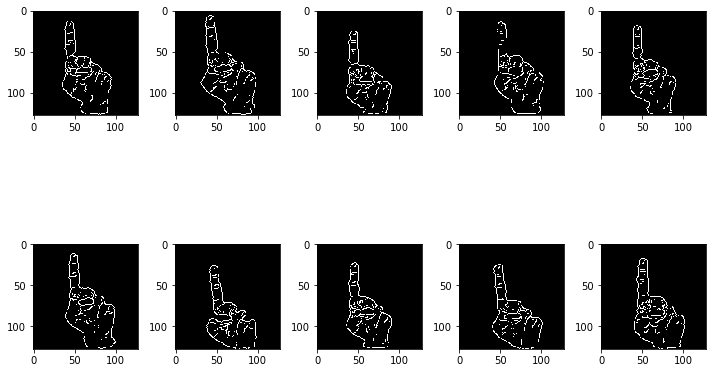

In [8]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(128, 128) , cmap = "gray")
        k += 1
    plt.tight_layout()  

In [9]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Part 2 : Model training

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [11]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 31 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 75)      750       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 75)      300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 50)        0

In [12]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 8) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
3565/3565 [==============================] - 1003s 281ms/step - loss: 0.3046 - accuracy: 0.9344 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 2/20
3565/3565 [==============================] - 921s 258ms/step - loss: 0.0909 - accuracy: 0.9853 - val_loss: 0.1485 - val_accuracy: 0.9698
Epoch 3/20
3565/3565 [==============================] - 833s 234ms/step - loss: 0.0683 - accuracy: 0.9902 - val_loss: 4.5694e-06 - val_accuracy: 1.0000
Epoch 4/20
3565/3565 [==============================] - 824s 231ms/step - loss: 0.0497 - accuracy: 0.9937 - val_loss: 0.0611 - val_accuracy: 0.9926
Epoch 5/20
3565/3565 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9954
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3565/3565 [==============================] - 813s 228ms/step - loss: 0.0440 - accuracy: 0.9954 - val_loss: 0.0079 - val_accuracy: 0.9989
Epoch 6/20
3565/3565 [==============================] - 846s 237ms/step - loss: 0.0191 -

In [13]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

223/223 [==============================] - 35s 156ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


In [14]:
# reference link : https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# save model and architecture to single file
model.save("model_final.h5")
#save model into json format and weights in different file
# serialize model to JSON
model_json = model.to_json()
with open("model_json_format.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_json_final.h5")
print("Saved model to disk")

Saved model to disk


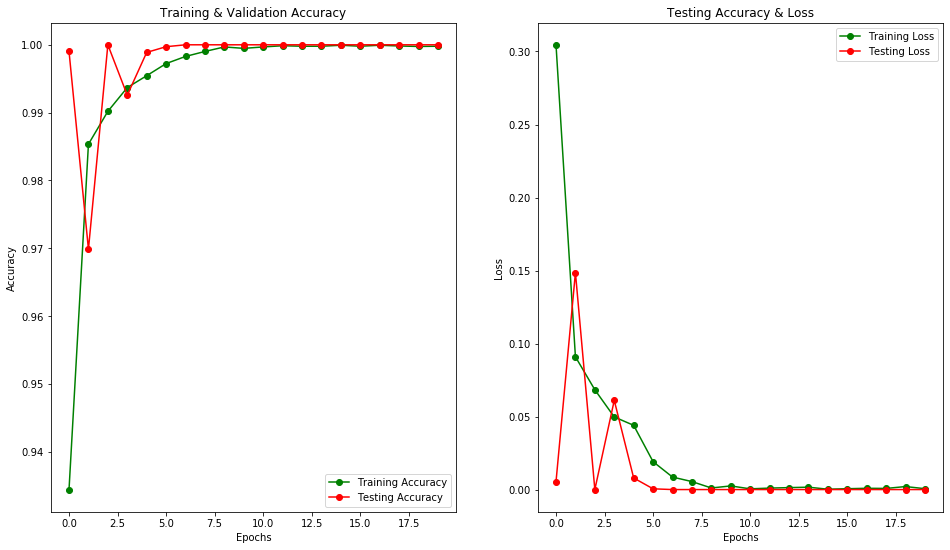

In [15]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [16]:
x,y = load_dataset("/home/jayant/PycharmProjects/Indian sign language character recognition/Dataset/test.csv",7130,128,128)
print(type(y[0]))

<class 'int'>


In [17]:
predictions = model.predict_classes(x_test)
print(predictions)
predictions +=1

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[ 0  0  0 ... 30 30 30]


In [19]:

classes = ["Class " + str(i) for i in range(32)]# if i != 9]
#classes = [0,1,2,3,4,5,6,7,8,9,10,11,12]
print(classes)
print(classification_report(y, predictions, target_names = classes))

['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12', 'Class 13', 'Class 14', 'Class 15', 'Class 16', 'Class 17', 'Class 18', 'Class 19', 'Class 20', 'Class 21', 'Class 22', 'Class 23', 'Class 24', 'Class 25', 'Class 26', 'Class 27', 'Class 28', 'Class 29', 'Class 30', 'Class 31']
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       230
     Class 1       1.00      1.00      1.00       230
     Class 2       1.00      1.00      1.00       230
     Class 3       1.00      1.00      1.00       230
     Class 4       1.00      1.00      1.00       230
     Class 5       0.00      0.00      0.00         0
     Class 6       0.00      0.00      0.00       230
     Class 7       0.00      0.00      0.00       230
     Class 8       0.00      0.00      0.00       230
     Class 9       0.00      0.00      0.00       230
    Class 10       0.00      0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

In [20]:
cm = confusion_matrix(y,predictions)

In [22]:
cm = pd.DataFrame(cm , index = [i for i in range(32)] , columns = [i for i in range(32)])

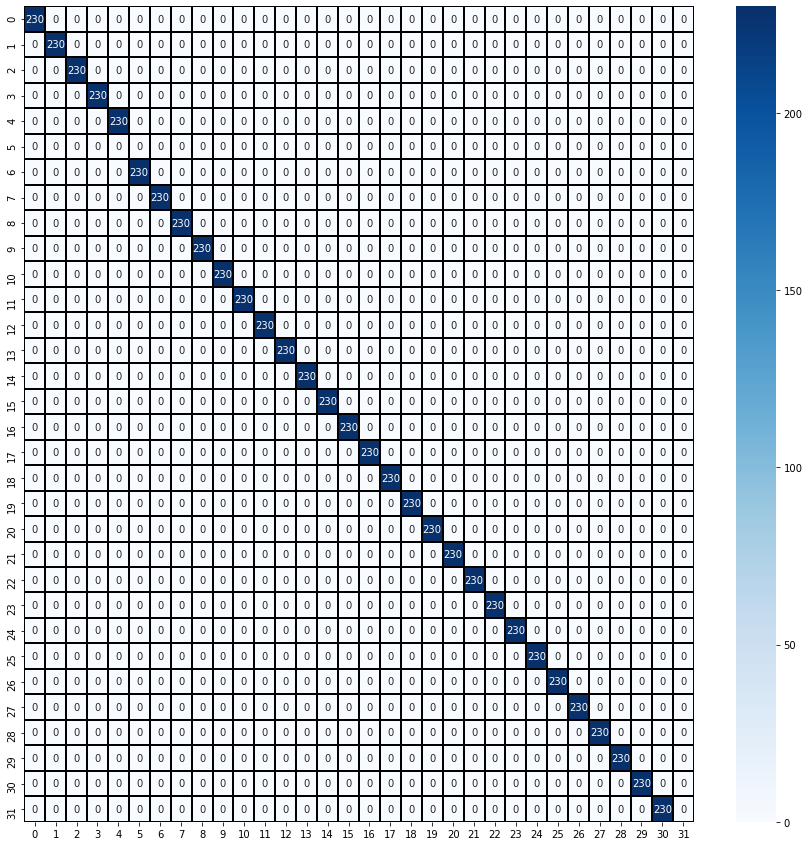

In [23]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [24]:
correct = np.nonzero(predictions == y)[0]

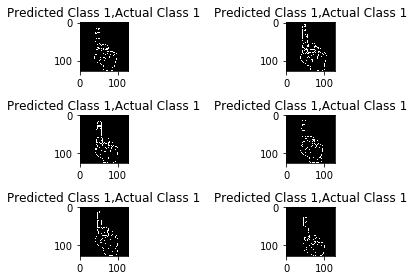

In [25]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(128,128), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

In [52]:
import tensorflow as tf
path ="/home/jayant/PycharmProjects/Indian-sign-language-recognition-master/data/Z/1198.jpg"
mod = tf.keras.models.load_model('model_final.h5')
img = cv2.imread(path)
img = get_canny_edge(img)[0]
#img = cv2.resize(img,(128,128))
img = img.reshape((1,128,128,1))
predictions = mod.predict(img)
print(predictions)
score = tf.nn.softmax(predictions[0])
classes = ['1', '2','3', '4', '5', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M',
                   'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U','W',
                   'X', 'Y', 'Z']
#classes = ['1', '2', '3','4','5', '7', '8','9','C','L','O','U']
print(
    "This image most likely belongs to {} "
    .format(classes[np.argmax(score)])
)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1.]]
This image most likely belongs to Z 
